In [1]:
import sys
import torch
from utils.config import Config
from utils.validation import Validation
from net.Unet import UNet
from utils.message import Msg
import segmentation_models_pytorch as smp
from net.baseNet import UNet_3d
import time
sys.path.append("./")


if __name__ == "__main__":
    start = time.time()
    # user configure
    config = Config()
    validation = Validation()
    msg = Msg()

    # model = UNet(n_channels=1, classes=2)
    model = smp.Unet('resnet34', classes=4, in_channels=1)
    # model = UNet_3d(in_channels=1, classes=4)
    # model = UNet3D(1, 4)

    model.to(device=config.device)
    validation.training(model, config)
    msg.end()
    stop = time.time()-start

    msg.norm("time", stop)



INFO: Starting training:
            Epochs:          50
            Batch size:      16
            Learning rate:   0.001
            Device:          cpu
        
INFO: 
            Training size:   1
            Validation size: 30 cases
        
Validation round: 100%|██████████| 1/1 [00:50<00:00, 50.23s/case]
                                                                 INFO: Validation cross entropy: 3.0518875122070312
INFO: Validation mean disc: [[0.00037482 0.        ]
 [0.00021091 0.        ]
 [0.         0.        ]]
Epoch1/50: 100%|██████████| 1/1 [00:53<00:00, 53.29s/img, loss (batch)=1.47]
INFO: Checkpoint 1 saved !
Epoch2/50: 100%|██████████| 1/1 [00:09<00:00,  9.10s/img, loss (batch)=1.2]


KeyboardInterrupt: 

<ipython-input-59-383bbb55f9c5>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  images = nib.load(root_image).get_data()
<ipython-input-59-383bbb55f9c5>:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = nib.load(root_mask).get_data()


2.639791937581274 -2.3407022106631987


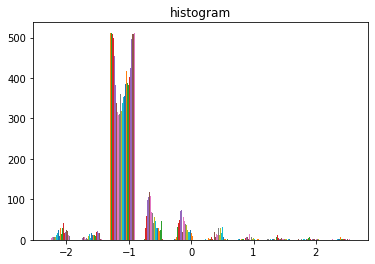

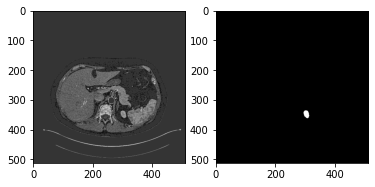

In [59]:
from utils.visualization import show_image_hist, show_single_view, show_views
import nibabel as nib
root_image = "/public/datasets/kidney/kits21/kits21/data/case_00000/imaging.nii.gz"
root_mask = "/public/datasets/kidney/kits21/kits21/data/case_00000/aggregated_AND_seg.nii.gz"
images = nib.load(root_image).get_data()
masks = nib.load(root_mask).get_data()
images[images < -79] = 0
images[images > 304] = 0
images = (images - 101) / 76.9
print(images.max(), images.min())
show_image_hist(images[100])
show_views(images[100],masks[100],cmap="gray")

In [148]:
import numpy as np
import SimpleITK as sitk
from glob import glob

def resize_image_itk(itkimage, newSize, resamplemethod=sitk.sitkNearestNeighbor):

    resampler = sitk.ResampleImageFilter()
    originSize = itkimage.GetSize()  # 原来的体素块尺寸
    originSpacing = itkimage.GetSpacing()
    newSize = np.array(newSize,float)
    factor = originSize / newSize
#     print(type(factor))
    newSpacing = originSpacing * factor
#     print(newSpacing)
    newSize = newSize.astype(np.int) # spacing肯定不能是整数
    resampler.SetReferenceImage(itkimage)  # 需要重新采样的目标图像
    resampler.SetSize(newSize.tolist())
    resampler.SetOutputSpacing(newSpacing.tolist())
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    resampler.SetInterpolator(resamplemethod)
    itkimgResampled = resampler.Execute(itkimage)  # 得到重新采样后的图像
    return itkimgResampled


def origin_sample(itkimage, spacing, resamplemethod=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    originSize = itkimage.GetSize()  # 原来的体素块尺寸
    originSpacing = itkimage.GetSpacing()
#     print(originSpacing)
    factor = np.array(spacing) / originSpacing 
    newSize = originSize / factor
#     print(factor,originSize,newSize)
    newSize = newSize.astype(np.int) # spacing肯定不能是整数
    resampler.SetReferenceImage(itkimage)  # 需要重新采样的目标图像
    resampler.SetSize(newSize.tolist())
    resampler.SetOutputSpacing(spacing)
    resampler.SetTransform(sitk.Transform(3, sitk.sitkIdentity))
    resampler.SetInterpolator(resamplemethod)
    itkimgResampled = resampler.Execute(itkimage)  # 得到重新采样后的图像
    return itkimgResampled    
    

image_file = "/public/datasets/kidney/kits21/kits21/data/case_00000/imaging.nii.gz"
root_mask = "/public/datasets/kidney/kits21/kits21/data/case_00000/aggregated_OR_seg.nii.gz"
itkimage = sitk.ReadImage(image_file)
itkmask = sitk.ReadImage(root_mask)
# print(itkmask.size)
# 采样之后的图片

itkimgResampled = resize_image_itk(itkimage, (128,256,256),resamplemethod= sitk.sitkLinear) #这里要注意：mask用最近邻插值，CT图像用线性插值
# print( sitk.GetArrayFromImage(itkimage).shape,sitk.GetArrayFromImage(itkimgResampled).shape)
mask_resample =  resize_image_itk(itkmask, (128,256,256),resamplemethod= sitk.sitkNearestNeighbor)

# show_views(sitk.GetArrayFromImage(mask_resample).transpose((2,1,0))[30],
#            sitk.GetArrayFromImage(itkimgResampled).transpose((2,1,0))[30],cmap="gray")
# print( sitk.GetArrayFromImage(mask_resample).max())

origin_image = sitk.GetArrayFromImage(itkimgResampled).transpose((2,1,0))
resample_mask = sitk.GetArrayFromImage(mask_resample).transpose((2,1,0))

# conbine_image = origin_image * resample_mask
# show_single_view(conbine_image,cmap="gray")
spacing = itkmask.GetSpacing()
# print(mask_resample.GetSize())
mask_origin = origin_sample(mask_resample, spacing,resamplemethod= sitk.sitkNearestNeighbor)
show_views(sitk.GetArrayFromImage(itkmask).transpose((2,1,0))[200],
           sitk.GetArrayFromImage(mask_origin).transpose((2,1,0))[200])

AttributeError: 'Image' object has no attribute 'size'

30
torch.Size([266, 1, 512, 512])
torch.Size([512, 512])


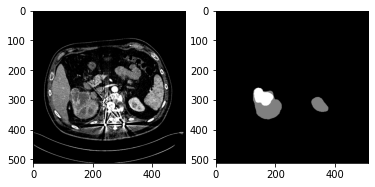

19751
torch.Size([1, 512, 512])
torch.Size([512, 512])


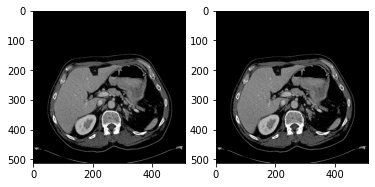

In [19]:

from torch.utils.data import Dataset
import torch
import numpy as np
from os.path import splitext
import os
from glob import glob
import sys
import warnings
from utils.config import config
from utils.convert import  convert
from utils.visualization import show_views
sys.path.append("..")
import cv2
# warnings.filterwarnings("ignore")


class BaseDataset(Dataset):

    def __init__(self, image_root, mask_root, is_val=False):
        """

        :param image_root:
        :param mask_root:
        :param is_val:  Tre：evaluation the performance
        """
        super(BaseDataset, self).__init__()
        self.image_root = image_root
        self.mask_root = mask_root
        # file name
        self.is_val = is_val
        self.ids = self.get_file(image_root)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):

        idx = self.ids[item]
        image_root = self.image_root
        mask_root = self.mask_root
        image_file = os.path.join(image_root, idx)
        mask_file = os.path.join(mask_root, idx)
        # print(mask_file, image_file)
        assert len(glob(image_file)) == 1, "image: no or multiple " + image_file
        assert len(glob(mask_file)) == 1, "mask: no or multiple " + mask_file
        if not self.is_val:
            image_np = np.load(image_file)
            mask_np = np.load(mask_file)
            # image_np = self.preprocess(image_np, 1000,0)
            # if mask_np.shape[1] != mask_np.shape[0]:
            #    print(mask_np.shape, image_np.shape, image_file)
            mask_numpy = np.expand_dims(mask_np, axis=0)
            image_numpy = np.expand_dims(self.preprocess(image_np), axis=0)
            return {
                "image": torch.from_numpy(image_numpy.copy()).type(torch.FloatTensor),
                "mask": torch.from_numpy(mask_numpy.copy()).type(torch.FloatTensor),
            }
        else:
            image_np, spacing = convert.nii_2_np(image_file)
            mask_np, _ = convert.nii_2_np(mask_file)
            # image_np = self.preprocess(image_np, 1000,0)
            # print(image_np.shape)
            # if mask_np.shape[1] != mask_np.shape[0]:
            #     print(mask_np.shape, image_np.shape, image_file)
            mask_numpy = np.expand_dims(mask_np, axis=1)
            image_numpy = np.expand_dims(self.preprocess(image_np), axis=1)

            return {
                "image": torch.from_numpy(image_numpy.copy()).type(torch.FloatTensor),
                "mask": torch.from_numpy(mask_numpy.copy()).type(torch.FloatTensor),
                "spacing": torch.from_numpy(spacing).type(torch.FloatTensor)
            }

    # 获取目录下的文件路径名
    def get_file(self, image_root):
        ids = list()
        if not self.is_val:
            for file in os.listdir(image_root):
                if file.endswith(".npy"):
                    ids.append(file)
        else:
            for file in os.listdir(image_root):
                if file.endswith(".gz"):
                    ids.append(file)
        return ids

    @staticmethod
    def preprocess(image):
        """
        input a image to normalization argument the region:[h,w]
        :param image: a image metric
        :return: preprocess
        """
        image[image < -79] = -79
        image[image > 304] = 304
        image = (image - 101) / 76.9
        return image


if __name__ == "__main__":
    image_root = config.val_image_path
    mask_root = config.val_mask_path
    base_dataset = BaseDataset(image_root, mask_root, is_val=True)
    print(len(base_dataset))
    index = 1
    images = base_dataset[index]["image"]
    print(images.shape)
    images = base_dataset[index]["image"][150][0]
    mask = base_dataset[index]["mask"][150][0]
    print(images.shape)
    show_views(images, mask, cmap="gray")
    
    image_root = config.image_root
    mask_root = config.mask_root
    base_dataset = BaseDataset(image_root, mask_root)
    print(len(base_dataset))
    index = 50
    images = base_dataset[index]["image"]
    print(images.shape)
    images = base_dataset[index]["image"][0]
    print(images.shape)
    show_views(images, images, cmap="gray")



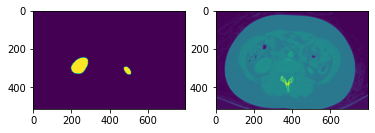

In [4]:
from utils.visualization import show_image_hist, show_single_view, show_views
from utils.config import config
import os 
image_root = os.path.join(config.image_root , "case_00004_25.npy")

mask_root =os.path.join(config.mask_root , "case_00004_25.npy")
mask = np.load(mask_root)
image = np.load(image_root)
# base_dataset = KitsDataset(image_root, mask_root)
# print(len(base_dataset.ids))
show_views(mask,image)

torch.Size([26, 512, 512])


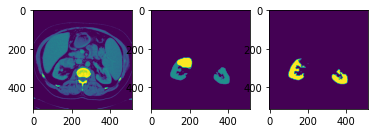

In [26]:
"""
1. predict patient nodule
"""

import torch
from utils.config import Config
from utils.message import Msg
from utils.validation import Validation
from net.Unet import UNet,UNet_2_skip
from utils.save import Save
from utils.convert import Convert
from utils.visualization import show_views
import segmentation_models_pytorch as smp
from net.baseNet import UNet_3d
from data.kits_dataset import KitsDataset
from data.BasisDataset import BaseDataset
from utils.visualization import show_image_hist, show_single_view, show_views
import os
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME

from net.Unet import UNet
if __name__ == "__main__":
    msg = Msg()
    config = Config()
    validation = Validation()
    convert_file = Convert()
    save = Save()

    # model = UNet(n_channels=1, classes=2)
    config.pre_model_path = "./ResNetUNet_Adam/CP_epoch6.pth"
#     model = UNet_2_skip(n_channels=1, classes=4)
    model = UNet(n_channels=1, classes=4)

#     model = UNet_3d(in_channels=1, classes=4)
    model.load_state_dict(torch.load(config.pre_model_path,
                                     map_location=config.device))
    model.to(device=config.device)

    # raw image root
    image_root = os.path.join(config.val_image_path , "case_00270.nii.gz")

    mask_root =os.path.join(config.val_mask_path , "case_00270.nii.gz")

    
#     xcd fix
    patient_name = ""
#     images,_ = convert_file.nii_2_np(image_root)
#     mask ,spacing = convert_file.nii_2_np(mask_root)
# #     pri
#     images_numpy = torch.FloatTensor(images).unsqueeze(1)
#     true_mask= torch.FloatTensor(mask).unsqueeze(1)
    index = 10
    images = BaseDataset(config.val_image_path, config.val_mask_path,is_val=True)
    images_numpy = images[index]["image"].squeeze(1)
    true_mask= images[index]["mask"].squeeze(1)
    spacing= images[index]["spacing"]
    
    # nodulesegment
    # masks = validation.predict_all(model, images_numpy, config)
                        
    print(images_numpy.shape)
    masks = validation.predict_all(model, images_numpy, config)
#     # save
    slice  = 10
    show_views(images_numpy[slice], true_mask[slice],masks[slice])
         
#     msg.norm("masks len", len(masks))
#     msg.norm("mask shape", masks.shape)
#     msg.norm("image shape", images_numpy.shape)
#     print(validation.calculate_metrics(np.array(masks), np.array(true_mask),spacing))

#     save.save_2_nii(masks, save_path=config.save_path,
#                     patient_name="kidney")



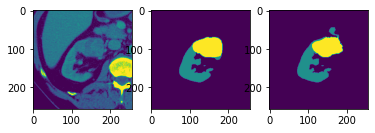

In [33]:
"""
1. predict patient nodule
"""

import torch
from utils.config import Config
from utils.message import Msg
from utils.validation import Validation
from utils.save import Save
from utils.convert import Convert
from utils.visualization import show_views
import segmentation_models_pytorch as smp
from net.baseNet import UNet_3d
from data.kits_dataset import KitsDataset
from data.BasisDataset import BaseDataset
from utils.visualization import show_image_hist, show_single_view, show_views
import os
from net.ResUnet import ResNetUNet
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME

if __name__ == "__main__":
    msg = Msg()
    config = Config()
    validation = Validation()
    convert_file = Convert()
    save = Save()

    # model = UNet(n_channels=1, classes=2)
    config.pre_model_path = "./ResNetUNet_second_Adam/CP_epoch3.pth"
#     model = UNet_2_skip(n_channels=1, classes=4)
    model = ResNetUNet(in_channel=1, classes=4)

#     model = UNet_3d(in_channels=1, classes=4)
    model.load_state_dict(torch.load(config.pre_model_path,
                                     map_location=config.device))
    model.to(device=config.device)
#     dataset = BaseDataset(config.val_image_crop,config.val_mask_crop,pre_pro=False)
#     mask = np.load(f"{config.val_mask_crop}/10_0_case_00288_.npy")
#     image = np.load(f"{config.val_image_crop}/10_0_case_00288_.npy")
#     mask = dataset[1]["mask"][0]
#     image = dataset[1]["image"][0]

    image_root = f"{config.val_image_crop}/10_0_case_00270_.npy"
    mask_root = f"{config.val_mask_crop}/10_0_case_00270_.npy"
    image_numpy = np.load(image_root)
    true_numpy = np.load(mask_root)
#     xcd fix
    patient_name = ""
#     images,_ = convert_file.nii_2_np(image_root)
#     mask ,spacing = convert_file.nii_2_np(mask_root)
# #     pri
#     images_numpy = torch.FloatTensor(images).unsqueeze(1)
#     true_mask= torch.FloatTensor(mask).unsqueeze(1)
                        
#     print(image_numpy)
    masks = validation.predict(model, np.expand_dims(image_numpy, 0), config)
#     # save
#     slice  = 10
    show_views(image_numpy, true_numpy,masks)
         


In [28]:
print(true_numpy.max())

2.0


In [ ]:
"""
    training, valida, predict tools

"""
import torch
import sys
from utils.config import Config
import gc
from data.BasisDataset import BaseDataset
from utils.message import Msg
from torch.utils.data import DataLoader, random_split
from torch import optim
from torch import nn
from tqdm import tqdm
from tensorboardX import SummaryWriter
from data.kits_dataset import KitsDataset
from utils.crop import read_image_json
import logging
import os
import torch.nn.functional as F
import numpy as np
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME
sys.path.append("../")
from threading import Thread


class Validation:
    def __init__(self):
        pass

    def training(self, model,
                 config: Config):
        """
        :param model: training model
        :param config: user config
        :return: None
        """
        msg = Msg()
        msg.training_conf(config)
        # dataset
        dataset = BaseDataset(config.image_root, config.mask_root, pre_pro=config.pro_pre)
        if config.second_network:
            var_dataset = BaseDataset(config.val_image_crop, config.val_mask_crop,
                                      pre_pro=config.pro_pre)
        else:
            var_dataset = BaseDataset(config.val_image_path, config.val_mask_path,
                                      is_val=True)
        # n_val = "30 cases"
        n_train = len(dataset)
        Msg.num_dataset(n_train, len(var_dataset))

        train = dataset
        train_loader = DataLoader(train, batch_size=config.batch_size,
                                  shuffle=True, num_workers=config.num_workers)

        # training
        # optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=config.lr)
        # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        # visualization
        # writer = SummaryWriter()
        writer = SummaryWriter(comment=f'{config.network}_{config.optimizer}')

        if config.loss == 0:
            # weights = torch.FloatTensor(config.entropy_weight).to(device=config.device)
            # criterion = nn.CrossEntropyLoss(weight=weights)
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.BCEWithLogitsLoss()
        # begin training
        global_step = 0

        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0
            with tqdm(total=n_train, desc=f'Epoch{epoch+1}/{config.epochs}', unit="img") as pbar:

                for batch in train_loader:
                    # read image
                    imgs = batch['image']
                    masks = batch['mask']

                    imgs = imgs.to(device=config.device, dtype=torch.float32)
                    mask_type = torch.float32 if config.loss == 1 else torch.long
                    true_masks = masks.to(device=config.device, dtype=mask_type)
                    if config.loss == 0:
                        true_masks = true_masks.squeeze(dim=1)
                    masks_pred = model(imgs)
                    # print("train", true_masks.shape, masks_pred.shape)
                    # print(imgs.max())
                    loss = criterion(masks_pred, true_masks)
                    epoch_loss += loss
                    # print(loss)
                    pbar.set_postfix(**{'loss (batch)': loss.item()})

                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_value_(model.parameters(), 0.1)
                    optimizer.step()

                    pbar.update(imgs.shape[0])
                    del imgs, masks, true_masks, masks_pred
                    gc.collect()
                global_step += 1
                # evaluation ,write data
                # if global_step % (n_train // (5 * config.batch_size)) == 0:
                #     for tag, value in model.named_parameters():
                #         tag = tag.replace('.', '/')
                #         writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                #         writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                # evaluation
                # valuation Loss
                # print("val")
                val_score, val_dice_sds = self.eval_net(model, config)
                writer.add_scalar(f'{config.network}/learning_rate', optimizer.param_groups[0]['lr'], global_step)
                disc_mean, sds_mean = np.mean(val_dice_sds, axis=0)
                writer.add_scalar(f'{config.network}/Loss/train', epoch_loss.item()/len(train_loader), global_step)

                writer.add_scalars(f'{config.network}/disc_sds', {"disc": disc_mean, "sds": sds_mean},
                                   global_step)
                writer.add_scalars(f'{config.network}/per_disc_sds',
                                   {"class1_disc": val_dice_sds[0][0], "class1_sds": val_dice_sds[0][1],
                                    "class2_disc": val_dice_sds[1][0], "class2_sds": val_dice_sds[1][1],
                                    "class3_disc": val_dice_sds[2][0], "class3_sds": val_dice_sds[2][1]},
                                   global_step)
                scheduler.step(val_score)
                # get kits ds and sd
                # val_ds_sd = self.kits_valuate(model, val_loader, config)
                logging.info('Validation cross entropy: {}'.format(val_score))
                logging.info('Validation mean disc: {}'.format(val_dice_sds))

                writer.add_scalar(f'{config.network}/Loss/test', val_score, global_step)
            # save model
            try:
                os.mkdir(f"{config.network}_{config.optimizer}")
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(model.state_dict(),
                       f"{config.network}_{config.optimizer}/CP_epoch{epoch + 1}.pth")
            logging.info(f'Checkpoint {epoch + 1} saved !')

        writer.close()

    def eval_net(self, model, config: Config, is_training=True) -> float:
        """
        evaluate the train network
        :param self:
        :param model:
        :param config: cpu or cuda
        :param is_training:training evaluate
        :return: score loss and kits disc and sds(3(disc)+3(sds)+2(mean))
        """
        kits_metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        model.eval()
        mask_type = torch.float32 if config.loss == 1 else torch.long
        if config.second_network:
            var_dataset = BaseDataset(config.val_image_crop, config.val_mask_crop,
                                      pre_pro=False)
            var_loader = DataLoader(var_dataset, batch_size=config.batch_size,
                                    shuffle=True, num_workers=config.num_workers)
        else:
            var_dataset = BaseDataset(config.val_image_path, config.val_mask_path,
                                      is_val=True)
        n_val = len(var_dataset)  # the number of batch

        tot = 0
        counter = len(var_dataset)
        # with tqdm(total=n_val, desc='Validation round', unit='case', leave=False) as pbar:
        if not config.second_network:
            counter = 0
            for case in var_dataset:
                imgs, true_masks = case['image'], case['mask']
                imgs = imgs.to(device=config.device, dtype=torch.float32)
                true_masks = true_masks.to(device=config.device, dtype=mask_type)
                spacing = case['spacing']
                imgs = imgs.to(device=config.device, dtype=torch.float32)

                case_pred = 0
                batch_size = 16
                # print(imgs.shape[0])
                if imgs.shape[0] > 600:
                    # break
                    continue
                counter += 1

                # 理论上分批次与全部批次预测结果一样：分成64批次
                for batch in range(imgs.shape[0]//batch_size+1):
                    with torch.no_grad():
                        if imgs.shape[0] <= batch*batch_size:
                            break
                        if batch == len(imgs) // batch_size:
                            mask_pred = model(imgs[batch*batch_size:])
                        else:
                            mask_pred = model(imgs[batch*batch_size:(batch+1)*batch_size])
                        if batch == 0:
                            case_pred = mask_pred
                        else:
                            case_pred = torch.cat([case_pred, mask_pred], dim=0)
                        del mask_pred
                        gc.collect()
                if config.loss == 0:
                    true_masks = true_masks.squeeze(dim=1)

                    tot += F.cross_entropy(case_pred, true_masks).item()
                    # print(true_masks.shape, case_pred.shape)
                    case_pred = case_pred.argmax(dim=1)
                    # 将整个case合并
                    case_pred = case_pred.squeeze(dim=1)
                    # images, masks = crop_images()
                    kits_metrics += self.calculate_metrics(case_pred.cpu().numpy(),
                                                           true_masks.cpu().numpy(),
                                                           spacing.cpu().numpy())
                    # kits_metrics = 0
                del case_pred, imgs, true_masks
                gc.collect()
                # pbar.update()
        else:
            counter = 0
            for case in var_dataset:
                imgs, true_masks = case['image'], case['mask']
                imgs = imgs.to(device=config.device, dtype=torch.float32)
                true_masks = true_masks.to(device=config.device, dtype=mask_type)
                spacing = case['spacing']
                imgs = imgs.to(device=config.device, dtype=torch.float32)

                case_pred = 0
                batch_size = 16
                # print(imgs.shape[0])
                # if imgs.shape[0] > 600:
                #     # break
                #     continue
                counter += 1
                # case slice patch_count bbox[y y x x]
                crop_infos = read_image_json(config.image_json)
                crop_info = crop_infos[case.idx]
                crop_image, crop_mask = get_cube(imgs, true_masks, crop_info)

                # 理论上分批次与全部批次预测结果一样：分成64批次
                for batch in range(crop_image.shape[0] // batch_size + 1):
                    with torch.no_grad():
                        if crop_image.shape[0] <= batch * batch_size:
                            break
                        if batch == len(imgs) // batch_size:
                            mask_pred = model(crop_image[batch * batch_size:])
                        else:
                            mask_pred = model(crop_image[batch * batch_size:(batch + 1) * batch_size])
                        if batch == 0:
                            case_pred = mask_pred
                        else:
                            case_pred = torch.cat([case_pred, mask_pred], dim=0)
                        del mask_pred
                        gc.collect()
                crop_mask = crop_mask.squeeze(dim=1)

                tot += F.cross_entropy(case_pred, crop_mask).item()
                # print(true_masks.shape, case_pred.shape)
                case_pred = case_pred.argmax(dim=1)
                # 将整个case合并
                # case_pred = case_pred.squeeze(dim=1)
                # images, masks = crop_images()
                # combing image mask
                combine_pred = combine_image(case_pred, imgs.shape, crop_info)

                kits_metrics += self.calculate_metrics(combine_pred.cpu().numpy(),
                                                       true_masks.cpu().numpy(),
                                                       spacing.cpu().numpy())
                    # kits_metrics = 0
                del case_pred, imgs, true_masks
                gc.collect()
        if is_training:
            model.train()
        return tot / counter, kits_metrics / counter

    def predict(self, model, image: np.ndarray, config: Config):
        """
        predict one image
        :param model: predict model
        :param image: a image numpy:shape[c,h,w]
        :param config: user configure
        :return: predict image shape [h,w]
        """
        model.eval()
        # print(image.shape)
        image = torch.FloatTensor(np.expand_dims(image, 0))
        image = image.to(device=config.device)
        # print(image.shape)
        with torch.no_grad():
            predict_img = model(image)
            if config.loss == 0:
                image = predict_img.argmax(dim=1)
            # 4D s*c*h*w
        output = torch.squeeze(image)
        output = output.float()

        if config.device == "cpu":
            return output.numpy()
        # print(output.cpu().numpy())
        return output.cpu().numpy()

    def predict_all(self, model, images, config, batch_size=64):
        """
        predict a patient CT image
        :param model:
        :param images: return a patient predict
        :param config:
        :param batch_size
        :return:
        """
        if len(images.shape) != 4:
            images = torch.FloatTensor(images).unsqueeze(dim=1)
        # for i in range(len(images)):
        #     # lung shape [h,w] to [c,h,w]
        #     lung = np.expand_dims(images[i], 1)
        #     print(lung.shape)
        #
        #     mask = self.predict(model, lung, config)
        #     masks.append(mask)
        model.eval()
        for batch in range(images.shape[0] // batch_size + 1):
            with torch.no_grad():
                # print(batch * batch_size, (batch + 1) * batch_size)
                if images.shape[0] <= batch * batch_size:
                    break
                if batch == len(images) // batch_size:
                    mask_pred = model(images[batch * batch_size:])
                else:
                    mask_pred = model(images[batch * batch_size:(batch + 1) * batch_size])
                if batch == 0:
                    case_pred = mask_pred
                else:
                    case_pred = torch.cat([case_pred, mask_pred], dim=0)
        case_pred = case_pred.argmax(dim=1)
        # 将整个case合并
        case_pred = case_pred.squeeze(dim=1)
        return case_pred

    @staticmethod
    def calculate_metrics(masks, ground_trues, spacing=None, second_network=False):
        """
        :param ground_trues: [b,d,w,h]
        :param masks: [b,d,w,h]
        :param spacing: [b,d,w,h]
        :return: ndarray:[3,2]
        """
        # calculate per metrics
        # 数据量大，计算慢（多线程）：多个线程一起结束
        metrics_thread = list()
        bs_metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        # 遍历每个batch size的矩阵
        # print("gt_len: "+str(len(ground_trues)))
        # for per_case in range(len(ground_trues)):
        metrics_case = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        for i, hec in enumerate(HEC_NAME_LIST):
            if second_network:
                metrics_case[i] = compute_disc_for_slice(masks, ground_trues,
                                                         KITS_HEC_LABEL_MAPPING[hec])
            else:
                metrics_case[i] = compute_metrics_for_label(masks, ground_trues,
                                                            KITS_HEC_LABEL_MAPPING[hec],
                                                            tuple(spacing),
                                                            sd_tolerance_mm=HEC_SD_TOLERANCES_MM[hec])
            #     metrics_thread.append(Metrics_thread(ground_trues[per_case],
            #                                          masks[per_case],
            #                                          tuple(spacing[per_case]),
            #                                          hec))
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_thread[i].start()
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_thread[i].join()
            #     print("end")
            #
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_case[i] = metrics_thread[i].get_result()
            # bs_metrics += metrics_case
        return metrics_case

    def network_optimizer(self):
        pass

    @staticmethod
    def choose_network(config: Config):
        if config.optimizer == "SGD":
            pass


class Metrics_thread(Thread):
    def __init__(self, ground_trues, masks, spacing, hec):
        Thread.__init__(self)
        self.result = 0
        self.ground_trues = ground_trues
        self.masks = masks
        self.spacing = spacing
        self.hec = hec

    def run(self):
        # print("start")
        self.result = compute_metrics_for_label(self.ground_trues, self.masks,
                                                KITS_HEC_LABEL_MAPPING[self.hec],
                                                self.spacing,
                                                sd_tolerance_mm=HEC_SD_TOLERANCES_MM[self.hec])

    def get_result(self):
        return self.result


def get_cube(image, mask, crop_info: dict):
    """
    get crop image cube
    :param image: [n,1,h,w]
    :param mask: [n,1,h,w]
    :param crop_info: {slice,i,bbox}
    :return: image， mask([n,1,h,w])
    """
    image_crop = torch.zeros((len(crop_info), 1, 256, 256))
    mask_crop = torch.zeros((len(crop_i

case_00281.nii.gz


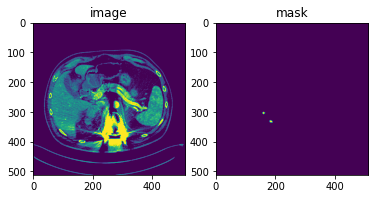

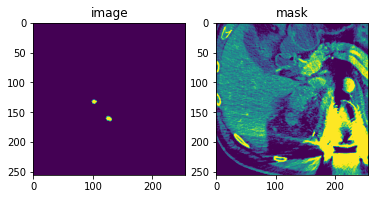

torch.Size([111, 1, 512, 512]) torch.Size([111, 1, 512, 512])
23


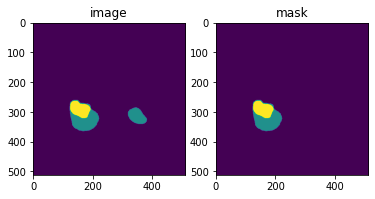

24


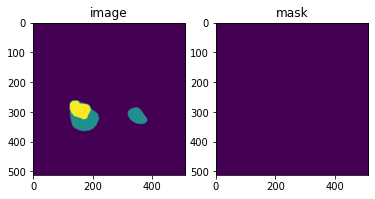

25


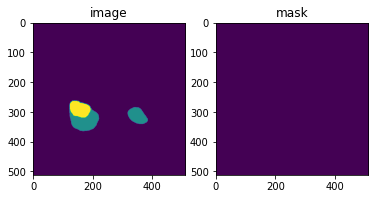

26


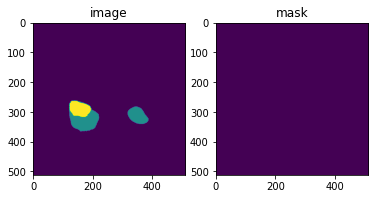

27


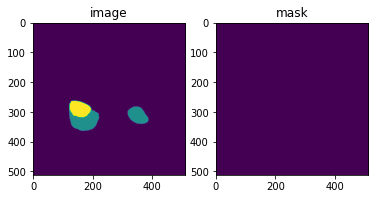

28


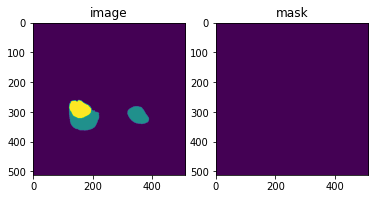

29


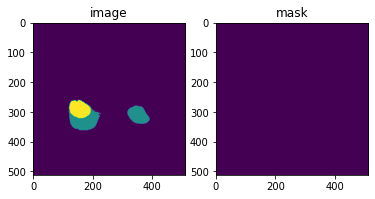

30


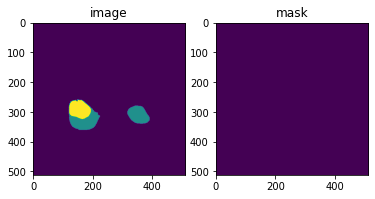

31


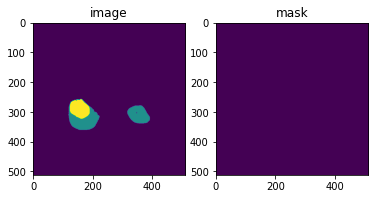

32


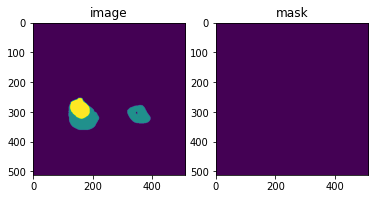

33


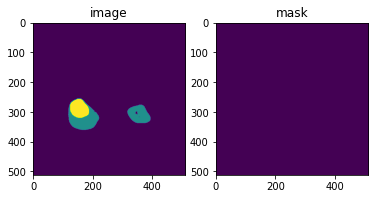

34


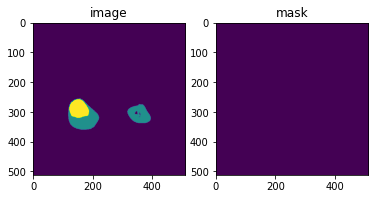

35


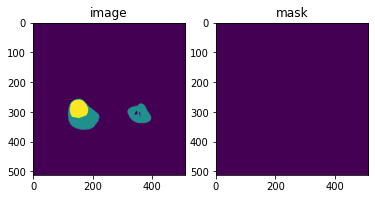

36


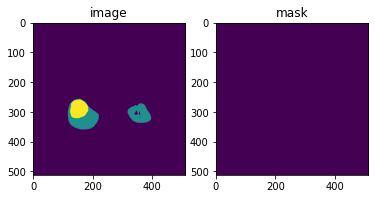

37


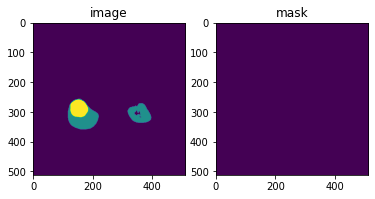

38


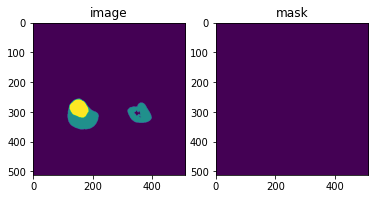

39


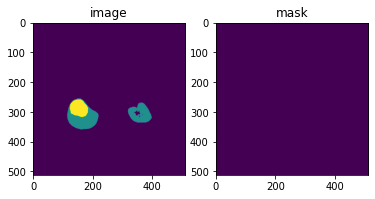

40


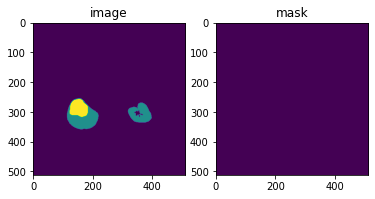

41


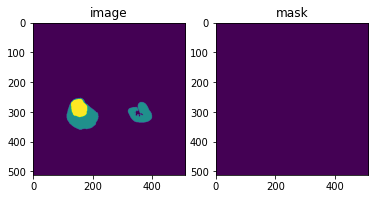

42


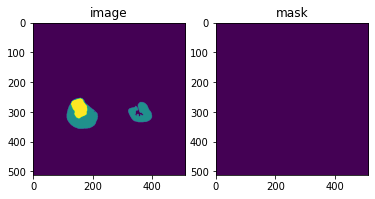

43


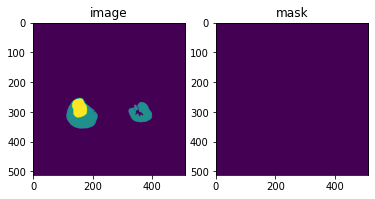

44


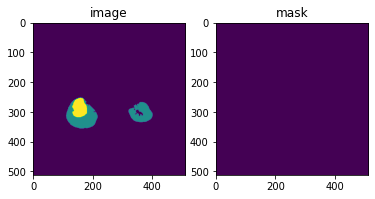

45


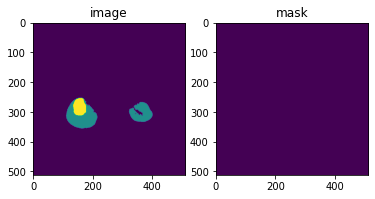

46


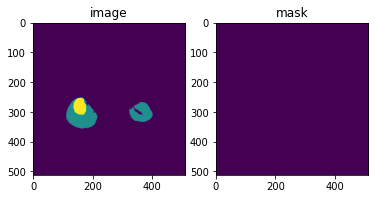

47


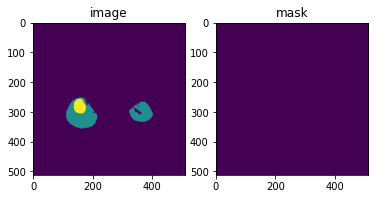

48


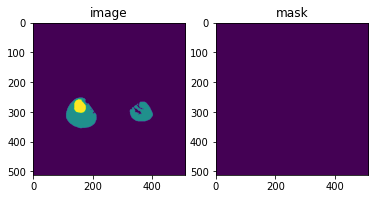

49


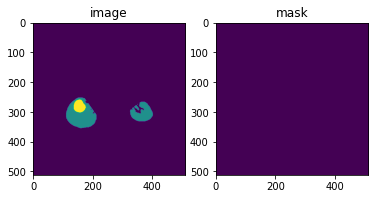

50


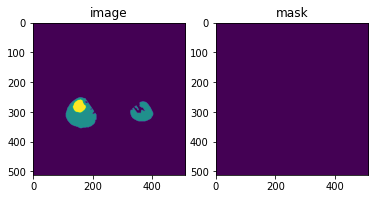

51


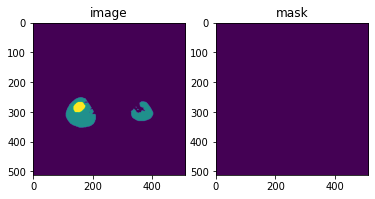

52


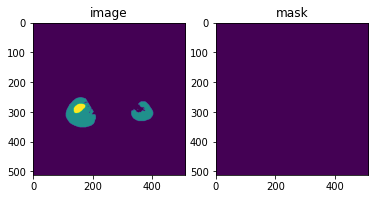

53


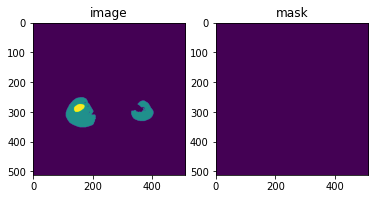

54


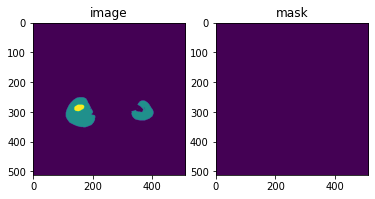

55


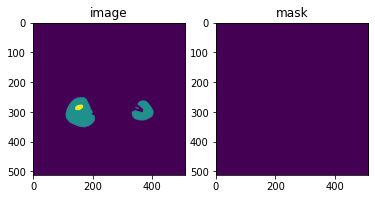

56


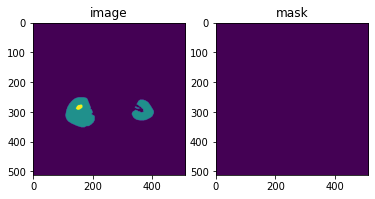

57


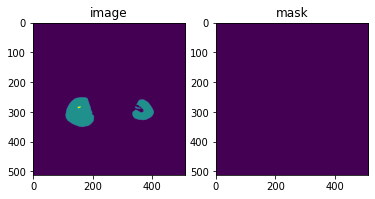

58


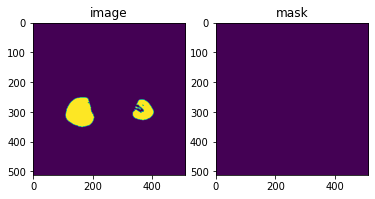

59


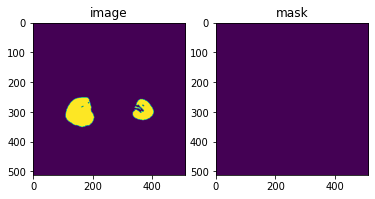

60


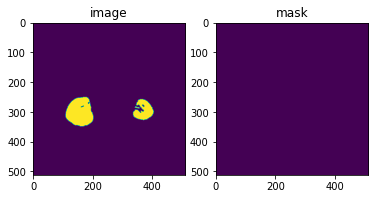

61


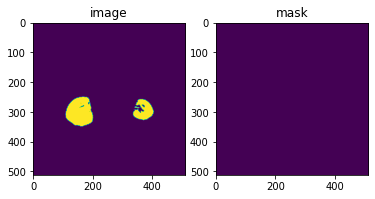

62


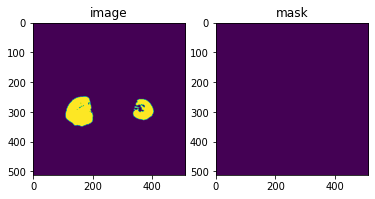

63


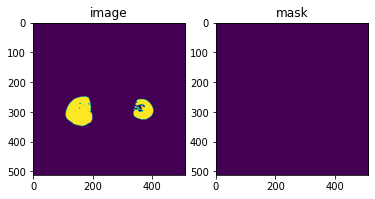

64


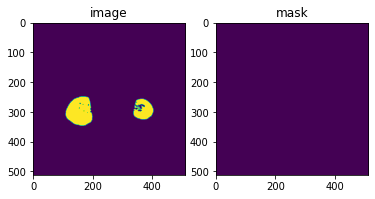

65


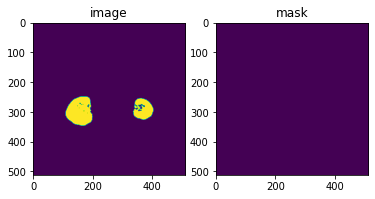

66


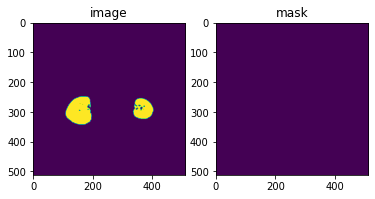

67


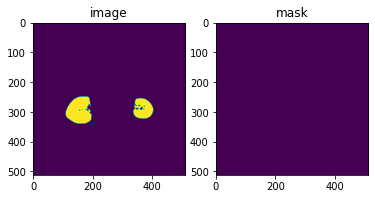

68


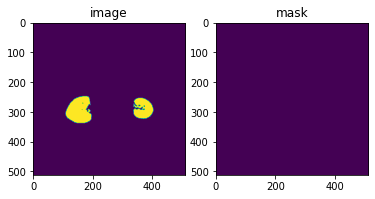

69


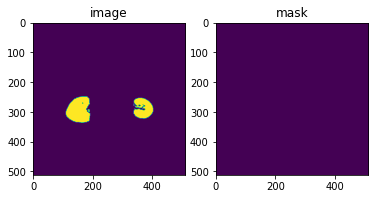

70


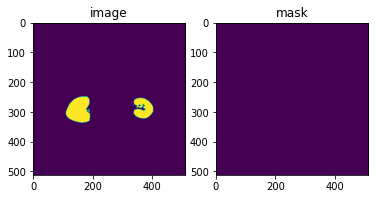

71


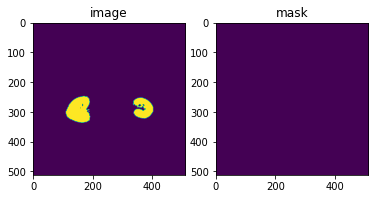

72


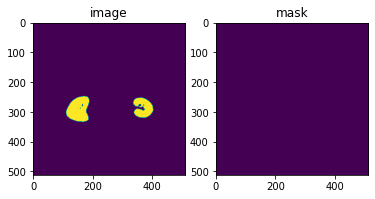

73


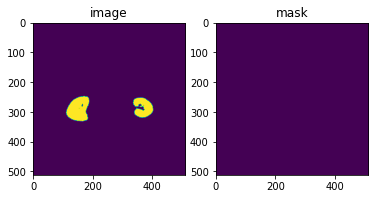

74


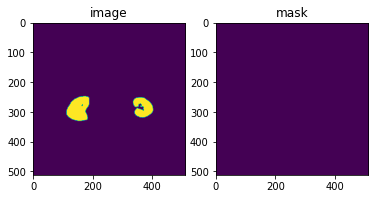

75


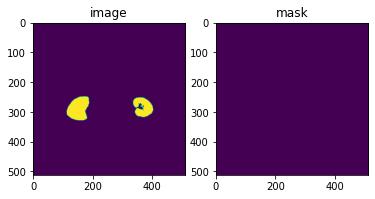

76


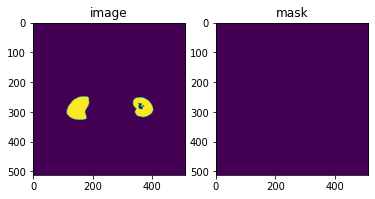

77


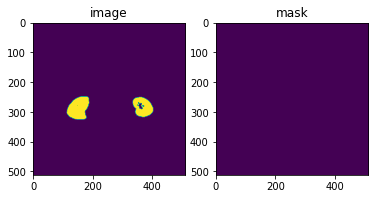

78


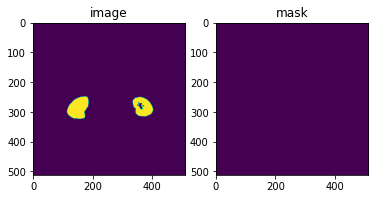

79


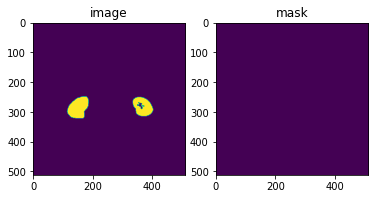

80


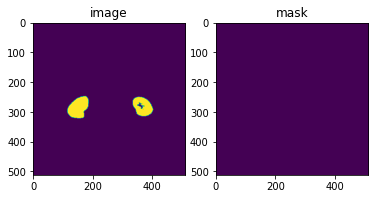

81


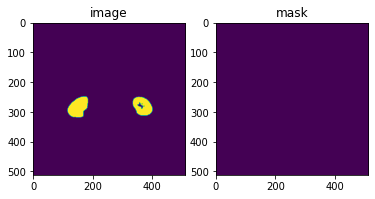

82


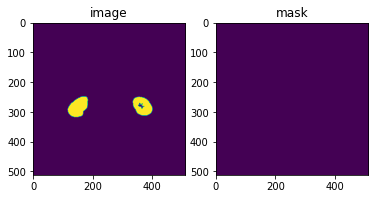

83


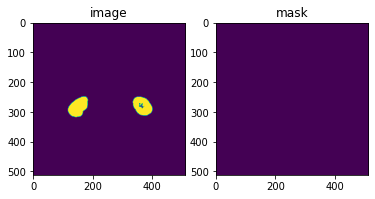

84


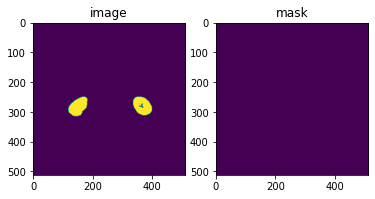

85


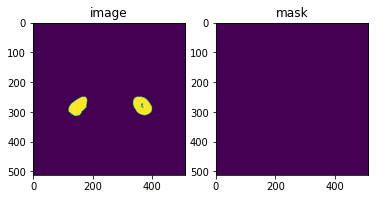

86


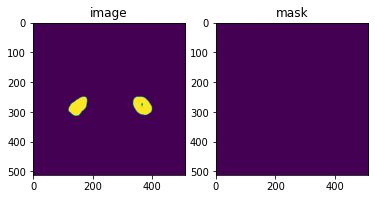

87


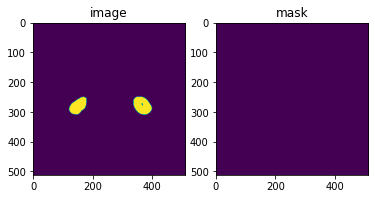

88


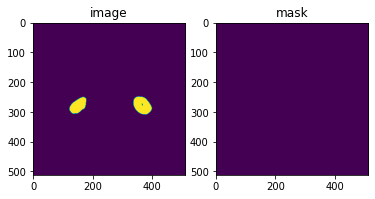

89


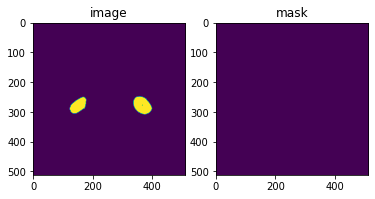

90


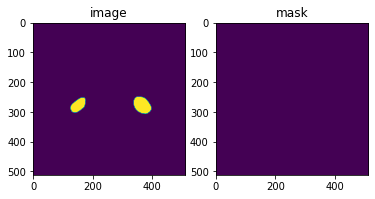

91


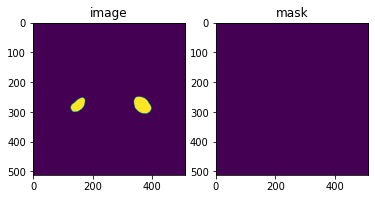

92


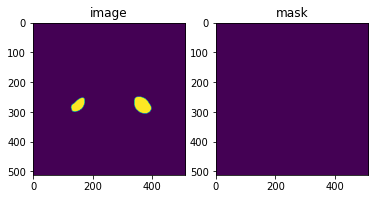

93


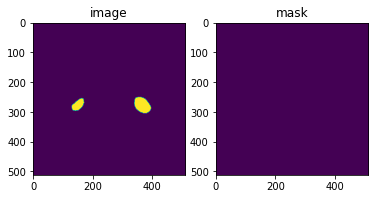

94


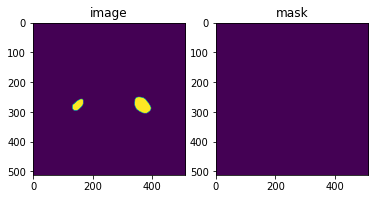

95


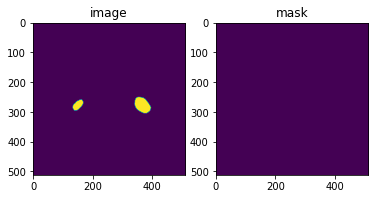

96


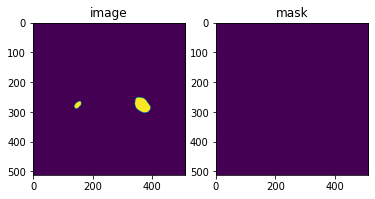

97


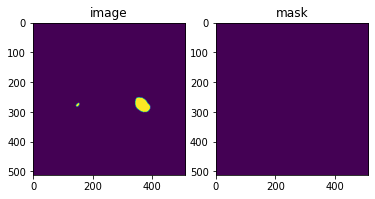

98


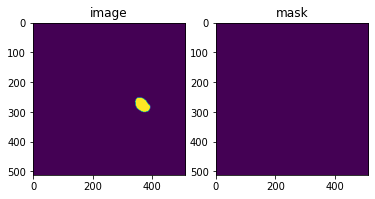

99


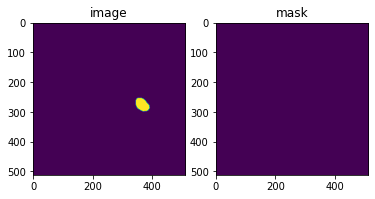

100


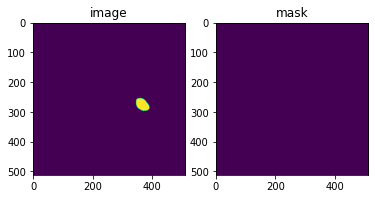

101


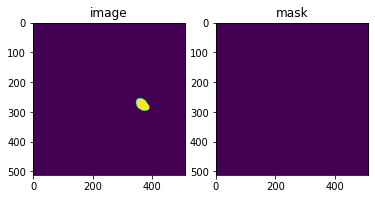

102


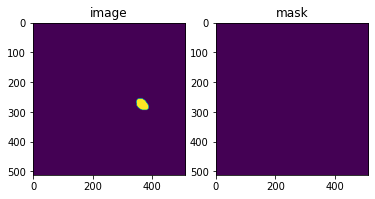

103


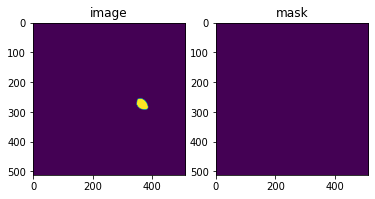

104


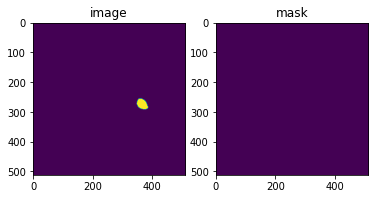

105


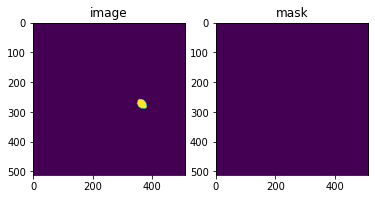

106


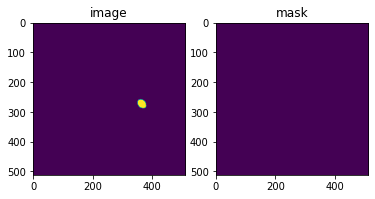

107


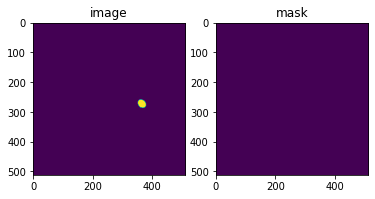

108


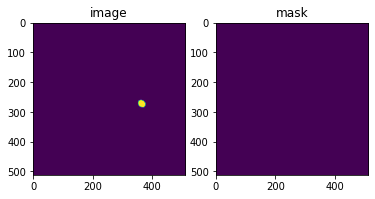

109


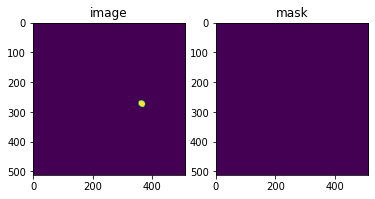

110


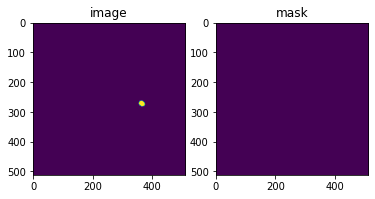

tensor(659610)


In [11]:
"""
    training, valida, predict tools

"""
import torch
import sys
from utils.config import Config
import gc
from data.BasisDataset import BaseDataset
from utils.message import Msg
from torch.utils.data import DataLoader, random_split
from torch import optim
from torch import nn
from tqdm import tqdm
from tensorboardX import SummaryWriter
from data.kits_dataset import KitsDataset
from utils.crop import read_image_json
import logging
import os
import torch.nn.functional as F
import numpy as np
from utils.metrics import compute_metrics_for_label, compute_disc_for_slice
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME
sys.path.append("../")
from threading import Thread
import cv2

class Validation:
    def __init__(self):
        pass

    def training(self, model,
                 config: Config):
        """
        :param model: training model
        :param config: user config
        :return: None
        """
        msg = Msg()
        msg.training_conf(config)
        # dataset
        dataset = BaseDataset(config.image_root, config.mask_root, pre_pro=config.pro_pre)
        if config.second_network:
            var_dataset = BaseDataset(config.val_image_crop, config.val_mask_crop,
                                      pre_pro=config.pro_pre)
        else:
            var_dataset = BaseDataset(config.val_image_path, config.val_mask_path,
                                      is_val=True)
        # n_val = "30 cases"
        n_train = len(dataset)
        Msg.num_dataset(n_train, len(var_dataset))

        train = dataset
        train_loader = DataLoader(train, batch_size=config.batch_size,
                                  shuffle=True, num_workers=config.num_workers)

        # training
        # optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=config.lr)
        # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        # visualization
        # writer = SummaryWriter()
        writer = SummaryWriter(comment=f'{config.network}_{config.optimizer}')

        if config.loss == 0:
            # weights = torch.FloatTensor(config.entropy_weight).to(device=config.device)
            # criterion = nn.CrossEntropyLoss(weight=weights)
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.BCEWithLogitsLoss()
        # begin training
        global_step = 0

        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0
            with tqdm(total=n_train, desc=f'Epoch{epoch+1}/{config.epochs}', unit="img") as pbar:

                for batch in train_loader:
                    # read image
                    imgs = batch['image']
                    masks = batch['mask']

                    imgs = imgs.to(device=config.device, dtype=torch.float32)
                    mask_type = torch.float32 if config.loss == 1 else torch.long
                    true_masks = masks.to(device=config.device, dtype=mask_type)
                    if config.loss == 0:
                        true_masks = true_masks.squeeze(dim=1)
                    masks_pred = model(imgs)
                    # print("train", true_masks.shape, masks_pred.shape)
                    # print(imgs.max())
                    loss = criterion(masks_pred, true_masks)
                    epoch_loss += loss
                    # print(loss)
                    pbar.set_postfix(**{'loss (batch)': loss.item()})

                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_value_(model.parameters(), 0.1)
                    optimizer.step()

                    pbar.update(imgs.shape[0])
                    del imgs, masks, true_masks, masks_pred
                    gc.collect()
                global_step += 1
                # evaluation ,write data
                # if global_step % (n_train // (5 * config.batch_size)) == 0:
                #     for tag, value in model.named_parameters():
                #         tag = tag.replace('.', '/')
                #         writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                #         writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                # evaluation
                # valuation Loss
                # print("val")
                val_score, val_dice_sds = self.eval_net(model, config)
                writer.add_scalar(f'{config.network}/learning_rate', optimizer.param_groups[0]['lr'], global_step)
                disc_mean, sds_mean = np.mean(val_dice_sds, axis=0)
                writer.add_scalar(f'{config.network}/Loss/train', epoch_loss.item()/len(train_loader), global_step)

                writer.add_scalars(f'{config.network}/disc_sds', {"disc": disc_mean, "sds": sds_mean},
                                   global_step)
                writer.add_scalars(f'{config.network}/per_disc_sds',
                                   {"class1_disc": val_dice_sds[0][0], "class1_sds": val_dice_sds[0][1],
                                    "class2_disc": val_dice_sds[1][0], "class2_sds": val_dice_sds[1][1],
                                    "class3_disc": val_dice_sds[2][0], "class3_sds": val_dice_sds[2][1]},
                                   global_step)
                scheduler.step(val_score)
                # get kits ds and sd
                # val_ds_sd = self.kits_valuate(model, val_loader, config)
                logging.info('Validation cross entropy: {}'.format(val_score))
                logging.info('Validation mean disc: {}'.format(val_dice_sds))

                writer.add_scalar(f'{config.network}/Loss/test', val_score, global_step)
            # save model
            try:
                os.mkdir(f"{config.network}_{config.optimizer}")
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(model.state_dict(),
                       f"{config.network}_{config.optimizer}/CP_epoch{epoch + 1}.pth")
            logging.info(f'Checkpoint {epoch + 1} saved !')

        writer.close()

    def eval_net(self, model, config: Config, is_training=True) -> float:
        """
        evaluate the train network
        :param self:
        :param model:
        :param config: cpu or cuda
        :param is_training:training evaluate
        :return: score loss and kits disc and sds(3(disc)+3(sds)+2(mean))
        """
        kits_metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        model.eval()
        mask_type = torch.float32 if config.loss == 1 else torch.long
        if config.second_network:
            var_dataset = BaseDataset(config.val_image_crop, config.val_mask_crop,
                                      pre_pro=False)
            var_loader = DataLoader(var_dataset, batch_size=config.batch_size,
                                    shuffle=True, num_workers=config.num_workers)
        else:
            var_dataset = BaseDataset(config.val_image_path, config.val_mask_path,
                                      is_val=True)
        n_val = len(var_dataset)  # the number of batch

        tot = 0
        counter = len(var_dataset)
        # with tqdm(total=n_val, desc='Validation round', unit='case', leave=False) as pbar:
        if not config.second_network:
            counter = 0
            for case in var_dataset:
                imgs, true_masks = case['image'], case['mask']
                imgs = imgs.to(device=config.device, dtype=torch.float32)
                true_masks = true_masks.to(device=config.device, dtype=mask_type)
                spacing = case['spacing']
                imgs = imgs.to(device=config.device, dtype=torch.float32)

                case_pred = 0
                batch_size = 16
                # print(imgs.shape[0])
                if imgs.shape[0] > 600:
                    # break
                    continue
                counter += 1

                # 理论上分批次与全部批次预测结果一样：分成64批次
                for batch in range(imgs.shape[0]//batch_size+1):
                    with torch.no_grad():
                        if imgs.shape[0] <= batch*batch_size:
                            break
                        if batch == len(imgs) // batch_size:
                            mask_pred = model(imgs[batch*batch_size:])
                        else:
                            mask_pred = model(imgs[batch*batch_size:(batch+1)*batch_size])
                        if batch == 0:
                            case_pred = mask_pred
                        else:
                            case_pred = torch.cat([case_pred, mask_pred], dim=0)
                        del mask_pred
                        gc.collect()
                if config.loss == 0:
                    true_masks = true_masks.squeeze(dim=1)

                    tot += F.cross_entropy(case_pred, true_masks).item()
                    # print(true_masks.shape, case_pred.shape)
                    case_pred = case_pred.argmax(dim=1)
                    # 将整个case合并
                    case_pred = case_pred.squeeze(dim=1)
                    # images, masks = crop_images()
                    kits_metrics += self.calculate_metrics(case_pred.cpu().numpy(),
                                                           true_masks.cpu().numpy(),
                                                           spacing.cpu().numpy())
                    # kits_metrics = 0
                del case_pred, imgs, true_masks
                gc.collect()
                # pbar.update()
        else:
            counter = 0
            for case in var_dataset:
                imgs, true_masks = case['image'], case['mask']
                imgs = imgs.to(device=config.device, dtype=torch.float32)
                true_masks = true_masks.to(device=config.device, dtype=mask_type)
                spacing = case['spacing']
                imgs = imgs.to(device=config.device, dtype=torch.float32)

                case_pred = 0
                batch_size = 16
                # print(imgs.shape[0])
                # if imgs.shape[0] > 600:
                #     # break
                #     continue
                counter += 1
                # case slice patch_count bbox[y y x x]
                crop_infos = read_image_json(config.image_json)
                crop_info = crop_infos[case.idx]
                crop_image, crop_mask = get_cube(imgs, true_masks, crop_info)

                # 理论上分批次与全部批次预测结果一样：分成64批次
                for batch in range(crop_image.shape[0] // batch_size + 1):
                    with torch.no_grad():
                        if crop_image.shape[0] <= batch * batch_size:
                            break
                        if batch == len(imgs) // batch_size:
                            mask_pred = model(crop_image[batch * batch_size:])
                        else:
                            mask_pred = model(crop_image[batch * batch_size:(batch + 1) * batch_size])
                        if batch == 0:
                            case_pred = mask_pred
                        else:
                            case_pred = torch.cat([case_pred, mask_pred], dim=0)
                        del mask_pred
                        gc.collect()
                crop_mask = crop_mask.squeeze(dim=1)

                tot += F.cross_entropy(case_pred, crop_mask).item()
                # print(true_masks.shape, case_pred.shape)
                case_pred = case_pred.argmax(dim=1)
                # 将整个case合并
                # case_pred = case_pred.squeeze(dim=1)
                # images, masks = crop_images()
                # combing image mask
                combine_pred = combine_image(case_pred, imgs.shape, crop_info)

                kits_metrics += self.calculate_metrics(combine_pred.cpu().numpy(),
                                                       true_masks.cpu().numpy(),
                                                       spacing.cpu().numpy())
                    # kits_metrics = 0
                del case_pred, imgs, true_masks
                gc.collect()
        if is_training:
            model.train()
        return tot / counter, kits_metrics / counter

    def predict(self, model, image: np.ndarray, config: Config):
        """
        predict one image
        :param model: predict model
        :param image: a image numpy:shape[c,h,w]
        :param config: user configure
        :return: predict image shape [h,w]
        """
        model.eval()
        # print(image.shape)
        image = torch.FloatTensor(np.expand_dims(image, 0))
        image = image.to(device=config.device)
        # print(image.shape)
        with torch.no_grad():
            predict_img = model(image)
            if config.loss == 0:
                image = predict_img.argmax(dim=1)
            # 4D s*c*h*w
        output = torch.squeeze(image)
        output = output.float()

        if config.device == "cpu":
            return output.numpy()
        # print(output.cpu().numpy())
        return output.cpu().numpy()

    def predict_all(self, model, images, config, batch_size=64):
        """
        predict a patient CT image
        :param model:
        :param images: return a patient predict
        :param config:
        :param batch_size
        :return:
        """
        if len(images.shape) != 4:
            images = torch.FloatTensor(images).unsqueeze(dim=1)
        # for i in range(len(images)):
        #     # lung shape [h,w] to [c,h,w]
        #     lung = np.expand_dims(images[i], 1)
        #     print(lung.shape)
        #
        #     mask = self.predict(model, lung, config)
        #     masks.append(mask)
        model.eval()
        for batch in range(images.shape[0] // batch_size + 1):
            with torch.no_grad():
                # print(batch * batch_size, (batch + 1) * batch_size)
                if images.shape[0] <= batch * batch_size:
                    break
                if batch == len(images) // batch_size:
                    mask_pred = model(images[batch * batch_size:])
                else:
                    mask_pred = model(images[batch * batch_size:(batch + 1) * batch_size])
                if batch == 0:
                    case_pred = mask_pred
                else:
                    case_pred = torch.cat([case_pred, mask_pred], dim=0)
        case_pred = case_pred.argmax(dim=1)
        # 将整个case合并
        case_pred = case_pred.squeeze(dim=1)
        return case_pred

    @staticmethod
    def calculate_metrics(masks, ground_trues, spacing=None, second_network=False):
        """
        :param ground_trues: [b,d,w,h]
        :param masks: [b,d,w,h]
        :param spacing: [b,d,w,h]
        :return: ndarray:[3,2]
        """
        # calculate per metrics
        # 数据量大，计算慢（多线程）：多个线程一起结束
        metrics_thread = list()
        bs_metrics = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        # 遍历每个batch size的矩阵
        # print("gt_len: "+str(len(ground_trues)))
        # for per_case in range(len(ground_trues)):
        metrics_case = np.zeros((len(HEC_NAME_LIST), 2), dtype=float)
        for i, hec in enumerate(HEC_NAME_LIST):
            if second_network:
                metrics_case[i] = compute_disc_for_slice(masks, ground_trues,
                                                         KITS_HEC_LABEL_MAPPING[hec])
            else:
                metrics_case[i] = compute_metrics_for_label(masks, ground_trues,
                                                            KITS_HEC_LABEL_MAPPING[hec],
                                                            tuple(spacing),
                                                            sd_tolerance_mm=HEC_SD_TOLERANCES_MM[hec])
            #     metrics_thread.append(Metrics_thread(ground_trues[per_case],
            #                                          masks[per_case],
            #                                          tuple(spacing[per_case]),
            #                                          hec))
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_thread[i].start()
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_thread[i].join()
            #     print("end")
            #
            # for i in range(len(HEC_NAME_LIST)):
            #     metrics_case[i] = metrics_thread[i].get_result()
            # bs_metrics += metrics_case
        return metrics_case

    def network_optimizer(self):
        pass

    @staticmethod
    def choose_network(config: Config):
        if config.optimizer == "SGD":
            pass


class Metrics_thread(Thread):
    def __init__(self, ground_trues, masks, spacing, hec):
        Thread.__init__(self)
        self.result = 0
        self.ground_trues = ground_trues
        self.masks = masks
        self.spacing = spacing
        self.hec = hec

    def run(self):
        # print("start")
        self.result = compute_metrics_for_label(self.ground_trues, self.masks,
                                                KITS_HEC_LABEL_MAPPING[self.hec],
                                                self.spacing,
                                                sd_tolerance_mm=HEC_SD_TOLERANCES_MM[self.hec])

    def get_result(self):
        return self.result


def get_cube(image, mask, crop_info: dict):
    """
    get crop image cube
    :param image: [n,1,h,w]
    :param mask: [n,1,h,w]
    :param crop_info: {slice,i,bbox}
    :return: image， mask([n,1,h,w])
    """
    image_crop = torch.zeros((len(crop_info), 1, 256, 256))
    mask_crop = torch.zeros((len(crop_info), 1, 256, 256))
    for index in range(len(crop_info)):
        info = crop_info[index]
        bbox = info["bbox"]
        # print(info["slice"], bbox)
        image_crop[index][0].add_(image[info["slice"]][0][bbox[0]:bbox[1], bbox[2]:bbox[3]])
        mask_crop[index][0].add_(mask[info["slice"]][0][bbox[0]:bbox[1], bbox[2]:bbox[3]])

    return image_crop, mask_crop


def combine_image(mask, image, origin_shape, crop_info):
    """
    :param mask: [n,1,h1,w1]
    :param origin_shape: [origin_n,1,h,w]
    :param crop_info: [{slice index bbox}{}]
    :return:
    """
    combine_mask = np.zeros(origin_shape, np.uint8)
    # print(len(crop_info), len(mask))

    for index in range(len(mask)):
        info = crop_info[index]
        bbox = info["bbox"]
        # mask to 512*512 mask
        mask_temp = np.zeros_like(combine_mask[info["slice"]][0], dtype=np.uint8)
        # print(info["slice"], bbox)
        # show_views(image[index][0], mask[index][0])
        mask_temp[bbox[0]:bbox[1], bbox[2]:bbox[3]] = mask[index][0]
        combine_mask[info["slice"]][0] = cv2.bitwise_or(combine_mask[info["slice"]][0], mask_temp)
        # show_views(combine_mask[info["slice"]][0], mask_temp,
        #            image_title=["combine_mask", "mask_temp"])
#         break
    return torch.from_numpy(combine_mask)


if __name__ == "__main__":
    config = Config()
    var_dataset = BaseDataset(config.kits_val_image_path, config.kits_val_mask_path,
                              is_val=True)
    crop_infos = read_image_json(config.image_json)
    print(var_dataset.ids[1])
    from utils.visualization import show_views
    crop_info = crop_infos[var_dataset.ids[0]]
    # print(crop_info)
    image = var_dataset[1]["image"]
    mask = var_dataset[1]["mask"]
    show_views(image[0][0], mask[0][0])
    crop_image, crop_mask = get_cube(image, mask, crop_info)

    show_views(crop_mask[0][0], crop_image[0][0])
    combine_pre = combine_image(crop_mask, crop_image, image.shape, crop_info)
    # show_views(mask[1][0], combine_pre[1][0])
    # print((mask[1][0] != combine_pre[1][0]).sum())
    print(mask.shape, combine_pre.shape)
    for i in range(combine_pre.shape[0]):
        if (mask[i][0] != combine_pre[i][0]).sum() != 0:
            print(i)
            show_views(mask[i][0], combine_pre[i][0])
    print((mask != combine_pre).sum())


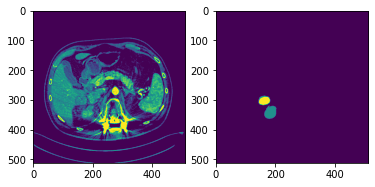

In [25]:
index = 6
show_views(image[index][0], mask[index][0])